# Evaluate MSA finetuning on EVICAN
A notebook that evaluates a fine tuned MSA model on the EVICAN test sets. Metrics are saved to a .json file and Model predictions are saved as plots to .pngs.

torch.Size([3, 3])
torch.Size([3, 3])


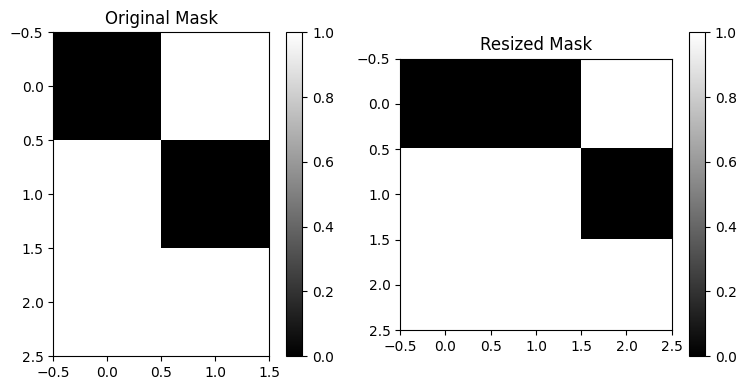

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

def resize_binary_mask(mask, target_size):
    resized_mask = cv2.resize(mask.numpy(), (target_size,target_size), interpolation=cv2.INTER_NEAREST)
    resized_mask_binary = torch.tensor((resized_mask > 0).astype(np.float64))
    return resized_mask_binary

def interpolate_img(image,target_size):
    original_height, original_width = image.shape[-2:]
    
    # Use the maximum of original size and crop size for interpolation
    interp_h = max(original_height, target_size)
    interp_w = max(original_width, target_size)

    # Interpolate the image using bilinear interpolation
    image = F.interpolate(image.unsqueeze(0).unsqueeze(0), size=(interp_h, interp_w), mode='bilinear').squeeze(0).squeeze(0)
    return image

# Example usage and visualization:
original_mask = torch.tensor([[0, 1],
                         [1, 0],
                         [1, 1]]).float()


target_size = 3
resized_mask = resize_binary_mask(original_mask, target_size)
print(resized_mask.shape)
resized_image = interpolate_img(original_mask, target_size)
print(resized_image.shape)

# Visualization
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_mask, cmap='gray', interpolation='nearest')
plt.title('Original Mask')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(resized_mask, cmap='gray', interpolation='nearest')
plt.title('Resized Mask')
plt.colorbar()

plt.tight_layout()
plt.show()


## Imports

In [41]:
# Import
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import torch.nn.functional as F

# Prompting imports
import prompter

# Metric imports
from torchmetrics import Accuracy, Precision, Recall, JaccardIndex, F1Score
from metrics import MeanIoU, PanopticQuality
from torchmetrics.detection.mean_ap import MeanAveragePrecision
calc_iou_matrix = MeanIoU._calc_iou_matrix

# Augmentation imports
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Model
from models.sam import SamPredictor, sam_model_registry

# Data
from dataset import *
from torch.utils.data import DataLoader
from prompter import *
from utils import *

usage: ipykernel_launcher.py [-h] [-net NET] [-baseline BASELINE]
                             [-seg_net SEG_NET] [-mod MOD]
                             [-exp_name EXP_NAME] [-type TYPE] [-vis VIS]
                             [-reverse REVERSE] [-pretrain PRETRAIN]
                             [-val_freq VAL_FREQ] [-gpu GPU]
                             [-gpu_device GPU_DEVICE] [-sim_gpu SIM_GPU]
                             [-epoch_ini EPOCH_INI] [-image_size IMAGE_SIZE]
                             [-out_size OUT_SIZE] [-patch_size PATCH_SIZE]
                             [-dim DIM] [-depth DEPTH] [-heads HEADS]
                             [-mlp_dim MLP_DIM] [-w W] [-b B] [-s S]
                             [-warm WARM] [-lr LR] [-uinch UINCH]
                             [-imp_lr IMP_LR] [-weights WEIGHTS]
                             [-base_weights BASE_WEIGHTS]
                             [-sim_weights SIM_WEIGHTS]
                             [-distributed DISTRIBUTED] [-data

SystemExit: 2

/home/zozchaab/anaconda3/envs/msa_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Path setup

In [5]:
# Put the original SAM weights here. 
# They can be downloaded from: 
# https://github.com/facebookresearch/segment-anything#model-checkpoints
SAM_CKPT = '/home/zozchaab/checkpoint/sam/sam_vit_b_01ec64.pth'

# Put your trained SAM model here
TUNED_MODEL_CKPT = '/home/zozchaab/Medical-SAM-Adapter/logs/random_sampling_per_component_2024_01_14_21_06_28/Model/checkpoint_best.pth'

# Data directory needed, where EVICAN should be saved to /loaded from
DATA_DIR = '/home/zozchaab/data'

# Define your save directory here
SAVE_ROOT = '/home/zozchaab/Medical_SAM_Adapter_Training/Evaluation/iqs_dv'
os.makedirs(SAVE_ROOT, exist_ok=True)

## Model Setup

In [3]:
# Make sure GPU is available
device = 0
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='GeForce RTX 3090', major=8, minor=6, total_memory=24268MB, multi_processor_count=82)

In [3]:
# This is needed to circumvent the argparser in the original repo
class Args:
    thd = False
    image_size = 120
args = Args()

tuned_ckpt = torch.load(TUNED_MODEL_CKPT)
sam = sam_model_registry['vit_b'](args, checkpoint=SAM_CKPT) #choose which checkpoint!!!
sam.load_state_dict(tuned_ckpt['state_dict'])
sam.eval()
sam = sam.to(device)
predictor = SamPredictor(sam)

## Data Setup

In [4]:
transform_msk_3D = transforms.Compose([
FillMissingCells(desired_shape=(1,120,120,120)),

])

transform_3D = transforms.Compose([
FillMissingCells(desired_shape=(1,120,120,120)),

])
transform_2d = transforms.Compose([

lambda x: x.expand(3, -1, -1),
transforms.Lambda(lambda x: x / 65535.0)

])

test_dataset = iqs_dv_01(data_path=os.path.join(args.data_path,'iqs_dv_01_test'),crop_size=args.crop_size, transform_3D=transform_3D, transform_msk_3D=transform_msk_3D,transform_2D=transform_2d)

nice_test_loader = DataLoader(
test_dataset,
batch_size=args.b,
shuffle=False,
num_workers=args.w,
collate_fn=collate_fn
) 


torch.Size([120, 90])


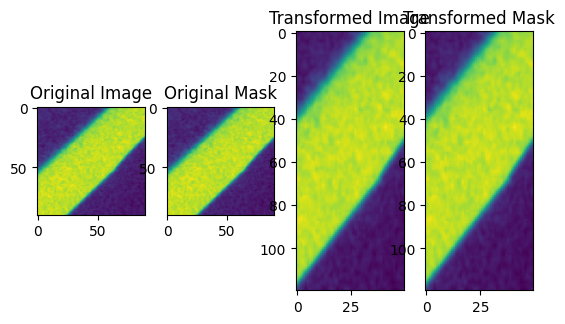

In [38]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import random
import h5py



# Sample image and mask tensors (replace these with your actual data)
img_path = '/mnt/data/backup/CRT_Efficient_Annotation_SAM/iqs/deepvision/iqs_dv_08/images/000406_f54eadef-9ab3-401f-a6fb-34106eb7e18d.h5'
with h5py.File(img_path, 'r') as img_h5:
    image_tensor = torch.from_numpy(img_h5['data']['data'][:].astype(np.float64)).unsqueeze(0)
    mask_tensor = torch.from_numpy(img_h5['data']['data'][:].astype(np.float64)).unsqueeze(0)
    

import numpy as np
def interpolate(image,crop_size):
    original_height, original_width = image.shape[-2:]
    
    # Use the maximum of original size and crop size for interpolation
    interp_h = max(original_height, crop_size[0])
    interp_w = max(original_width, crop_size[1])

    # Interpolate the image using bilinear interpolation
    image = F.interpolate(image.unsqueeze(0).unsqueeze(0), size=(interp_h, interp_w), mode='bilinear').squeeze(0).squeeze(0)
    return image

def crop(image,crop_size,top_left_x,top_left_y):
    # Crop the image
    return image[top_left_y:top_left_y + crop_size[0], top_left_x:top_left_x + crop_size[1]]

def crop_image_and_mask(image, mask, crop_size):
    
    image = interpolate(image,crop_size)
    mask = interpolate(mask,crop_size)
    # Randomly choose the top-left corner of the crop
    top_left_x = np.random.randint(0, image.shape[1] - crop_size[1] + 1)
    top_left_y = np.random.randint(0, image.shape[0] - crop_size[0] + 1)
    
    cropped_image = crop(image, crop_size,top_left_x,top_left_y)
    cropped_mask = crop(mask, crop_size, top_left_x, top_left_y)

    return cropped_image, cropped_mask

# Display the original image and mask
plt.subplot(1, 4, 1)
plt.imshow(image_tensor[0,:,:,24])
plt.title('Original Image')

plt.subplot(1,4, 2)
plt.imshow(mask_tensor[0,:,:,24])
plt.title('Original Mask')

# Define the crop size
crop_size = (120, 50)


# Apply transformations
transformed_image, transformed_mask = crop_image_and_mask(image_tensor[0,:,:,24],mask_tensor[0,:,:,24],crop_size)


# Display the transformed image and mask
plt.subplot(1, 4, 3)
plt.imshow(transformed_image)
plt.title('Transformed Image')

plt.subplot(1, 4, 4)
plt.imshow(transformed_mask)
plt.title('Transformed Mask')

plt.show()


## Prompt Setup

In [7]:
N_POINTS_MAX = 1 # Define the number of intial prompts generated using gaussian sampling
N_MAX_ITER_PROMPTS = 9 # Define the number of iterative prompts

## Test Loop

In [15]:
metrics_out = {}
vis_path = "home/zozchaab/vis"
# Iterate over the three dataset difficulties


folder = os.path.join(SAVE_ROOT, f'{N_POINTS_MAX}_{N_MAX_ITER_PROMPTS}')
os.makedirs(folder, exist_ok=True)

# Create metrics
metrics = [
    Accuracy(task='binary').to(device), 
    Precision(task='binary').to(device), 
    Recall(task='binary').to(device), 
    F1Score(task='binary').to(device), 
    JaccardIndex(task='binary').to(device),
]
miou = MeanIoU('optimal', False, False).to(device)
pq = PanopticQuality().to(device)

with torch.no_grad():
    with tqdm(total=len(test_dataset), unit='img') as pbar:
        for pack in nice_test_loader:
            preds = []
            scores = []
            prompts = []
            original_preds = []
            imgs = pack['image'].to(dtype = torch.float32, device = device)
            targets = pack['label'].to(dtype = torch.float32, device = device)
            names = pack['metadata']
            batch_loss = 0.0
            for img, mask in zip(imgs, targets):
                img_emb = sam.image_encoder(img.unsqueeze(0))
                # Create Prompts
            
                # Randomly sample number of prompts
                #n_points = np.random.randint(1, N_POINTS_MAX)
                #n_pos = np.random.randint(1, n_points) if n_points > 1 else 1
                #n_neg = np.random.randint(0, n_points-n_pos) if (n_points - n_pos) > 0 else 0
                n_neg = 0
                n_pos = 10
                pts, lbls = sample_from_mask(mask.squeeze(0), mode="random", n_pos=n_pos,n_neg = n_neg) 
    

                user_iter = 0 
                # Randomly add pseudo user input 
                #user_iter = np.random.randint(N_MAX_ITER_PROMPTS)
                for i in range(user_iter):
                    # print(f'User interaction {i+1}/{user_iter}')
                    
                    # Set prompt
                    prompt = (pts.unsqueeze(0).to(device), lbls.unsqueeze(0).to(device))
                    se, de = sam.prompt_encoder(
                        points=prompt,
                        boxes=None,
                        masks=None,
                    ) # type: ignore
                    
                    # Predict Mask
                    pred, _ = sam.mask_decoder(
                        image_embeddings=img_emb,
                        image_pe=net.prompt_encoder.get_dense_pe(),  # type: ignore
                        sparse_prompt_embeddings=se,
                        dense_prompt_embeddings=de, 
                        multimask_output=False,
                    ) # type: ignore
                    # Compare Prediction to GT
                    pred = F.interpolate(pred, mask.shape[-2:]) # This is a bit cumbersome, but the easiest fix for now
                    pred = pred.squeeze() > 0 #check this!!!
                    clusters = pred.cpu() != mask
                    # Sample point from largest error cluster 
                    new_prompt = find_best_new_prompt(clusters)
                    new_label = mask[new_prompt[0, 1], new_prompt[0, 0]].to(torch.int64)
                    pts = torch.concatenate([pts, new_prompt])
                    lbls = torch.concatenate([lbls, torch.tensor([new_label])])

                # Final Mask inference
                prompts.append([pts,lbls])
                prompt = (pts.unsqueeze(0).to(device), lbls.unsqueeze(0).to(device))

                # Set Prompt
                
                se, de = sam.prompt_encoder(
                    points=prompt,
                    boxes=None,
                    masks=None,
                ) # type: ignore

                # Predict Mask
                pred, score = sam.mask_decoder(
                    image_embeddings=img_emb,
                    image_pe=net.prompt_encoder.get_dense_pe(),  # type: ignore
                    sparse_prompt_embeddings=se,
                    dense_prompt_embeddings=de, 
                    multimask_output=False,
                ) # type: ignore
                original_preds.append((pred.squeeze(0) > 0).float())
                pred = F.interpolate(pred, mask.shape[-2:]).squeeze(0) # This is a bit cumbersome, but the easiest fix for now
                preds.append((pred > 0).float())
                scores.append(score)
                
                for m in metrics:
                    m.update(pred, mask.to(torch.uint8))
                pq.update(pred, mask)
                miou.update(pred, mask)
                
            scores = torch.stack(scores)
            
           
            vis = True
            if vis:
                visualize_batch(imgs=imgs, masks=targets, pred_masks=preds, names=names, prompts=prompts,original_preds=original_preds,save_path=vis_path)

            pbar.update()

ms = {str(m): m.compute().item() for m in metrics}
metrics_out = {
    **ms,
    'miou': {k:v.item() for k, v in miou.compute().items()},
    'pq': {k:v.item() for k, v in pq.compute().items()},
}

import json
with open(os.path.join(SAVE_ROOT, f'MSA_{N_POINTS_MAX}_{N_MAX_ITER_PROMPTS}_metrics.json'), 'w') as f:
    json.dump(metrics_out, f)

Test easy:   0%|          | 0/33 [00:00<?, ?img/s]

Test difficult: 100%|██████████| 32/32 [00:44<00:00,  1.40s/img]


In [16]:
metrics_out

{'easy': {'BinaryAccuracy()': 0.9986730217933655,
  'BinaryPrecision()': 0.897937536239624,
  'BinaryRecall()': 0.9202684760093689,
  'BinaryF1Score()': 0.9089658856391907,
  'BinaryJaccardIndex()': 0.8331232070922852,
  'miou': {'mIoU_micro': 0.8125030935846548,
   'mIoU_macro': 0.8085469603538513,
   'n_instances': 374,
   'n_images': 33},
  'map': {'map': 0.539608359336853,
   'map_50': 0.9223601222038269,
   'map_75': 0.5696019530296326,
   'map_small': 0.4207228422164917,
   'map_medium': 0.6256932616233826,
   'map_large': 0.549616277217865,
   'mar_1': 0.0521390363574028,
   'mar_10': 0.49251341819763184,
   'mar_100': 0.6644384860992432,
   'mar_small': 0.5386792421340942,
   'mar_medium': 0.7230414748191833,
   'mar_large': 0.6784313917160034,
   'map_per_class': -1.0,
   'mar_100_per_class': -1.0},
  'pq': {'panoptic_quality': 0.8189944624900818,
   'recognition_quality': 0.9861288070678711,
   'segmentation_quality': 0.8308647871017456}},
 'medium': {'BinaryAccuracy()': 0.99